In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import shap

In [97]:
# Load the dataset
df = pd.read_csv("/content/survey.csv")
print(df.head())

             Timestamp  Age  Gender         Country state self_employed  \
0  2014-08-27 11:29:31   37  Female   United States    IL           NaN   
1  2014-08-27 11:29:37   44       M   United States    IN           NaN   
2  2014-08-27 11:29:44   32    Male          Canada   NaN           NaN   
3  2014-08-27 11:29:46   31    Male  United Kingdom   NaN           NaN   
4  2014-08-27 11:30:22   31    Male   United States    TX           NaN   

  family_history treatment work_interfere    no_employees  ...  \
0             No       Yes          Often            6-25  ...   
1             No        No         Rarely  More than 1000  ...   
2             No        No         Rarely            6-25  ...   
3            Yes       Yes          Often          26-100  ...   
4             No        No          Never         100-500  ...   

                leave mental_health_consequence phys_health_consequence  \
0       Somewhat easy                        No                      No   
1 

Data Cleaning & Preprocessing
>> Check for Missing Values

In [98]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print(missing_data[missing_data['Missing Values'] > 0])

                Missing Values  Percentage
state                      515   40.905481
self_employed               18    1.429706
work_interfere             264   20.969023
comments                  1095   86.973789


In [99]:
# Drop unnecessary columns (excluding 'comments' if already dropped)
columns_to_drop = ['state', 'Timestamp']
if 'comments' in df.columns:
    columns_to_drop.append('comments')

df.drop(columns=columns_to_drop, inplace=True)

In [100]:
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,NaN,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,NaN,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


Handle Missing Values

In [101]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# Convert to string to handle mixed types
df['work_interfere'] = df['work_interfere'].astype(str)
df['self_employed'] = df['self_employed'].astype(str)

# Replace any placeholder NaNs (like 'nan' strings) with actual NaN values
df.replace({'work_interfere': {'nan': np.nan}, 'self_employed': {'nan': np.nan}}, inplace=True)

# Initialize SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation
df[['work_interfere']] = imputer.fit_transform(df[['work_interfere']])
df[['self_employed']] = imputer.fit_transform(df[['self_employed']])

# Check if missing values remain
print(df.isnull().sum())


Age                          0
Gender                       0
Country                      0
self_employed                0
family_history               0
treatment                    0
work_interfere               0
no_employees                 0
remote_work                  0
tech_company                 0
benefits                     0
care_options                 0
wellness_program             0
seek_help                    0
anonymity                    0
leave                        0
mental_health_consequence    0
phys_health_consequence      0
coworkers                    0
supervisor                   0
mental_health_interview      0
phys_health_interview        0
mental_vs_physical           0
obs_consequence              0
dtype: int64


Normalize Text Data
>> Convert Categorical Variables to Numeric


In [102]:

# Convert categorical variables to numeric using Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['Gender', 'Country', 'self_employed', 'family_history',
                       'treatment', 'work_interfere', 'no_employees', 'remote_work',
                       'tech_company', 'benefits', 'care_options', 'wellness_program',
                       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
                       'phys_health_consequence', 'coworkers', 'supervisor',
                       'mental_health_interview', 'phys_health_interview',
                       'mental_vs_physical', 'obs_consequence']

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

 Exploratory Data Analysis (EDA)
>> Visualize Relationships

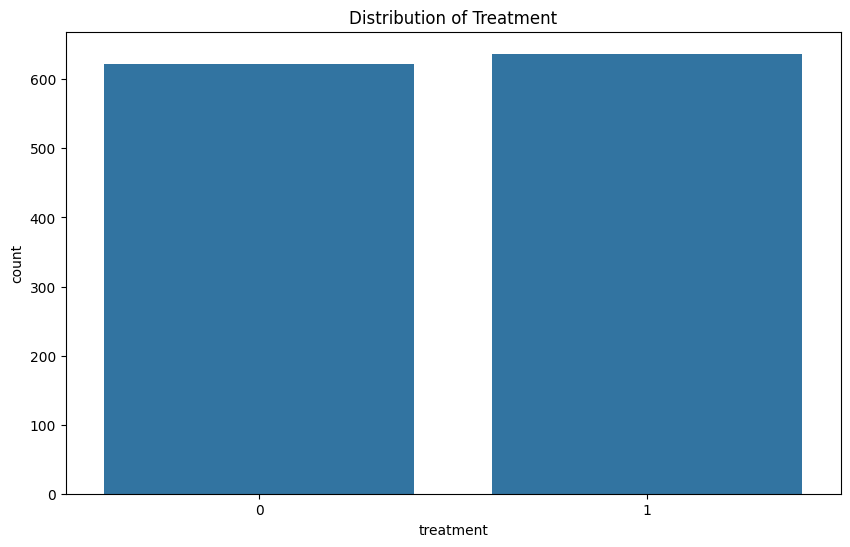

In [103]:
# Visualize the distribution of mental health conditions
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='treatment')
plt.title('Distribution of Treatment')
plt.show()

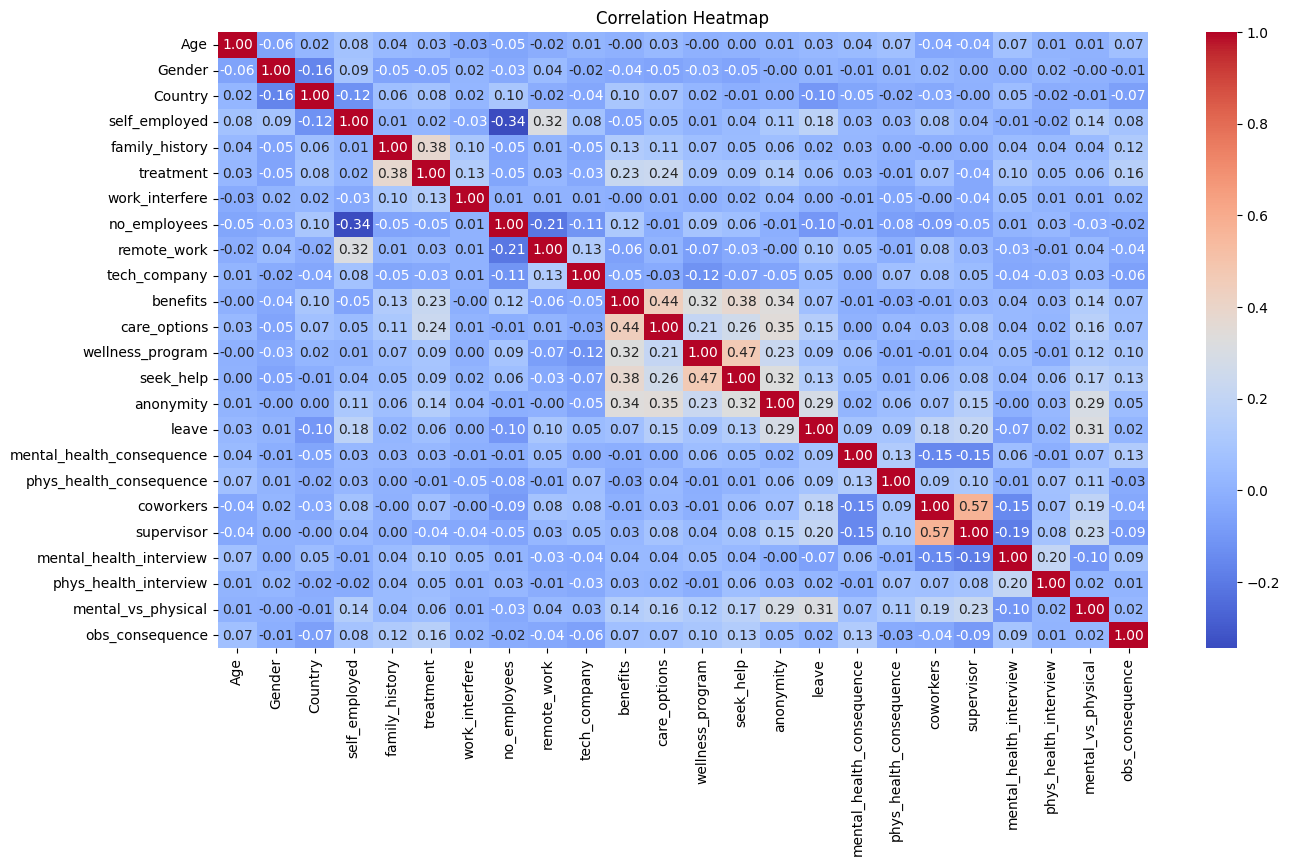

In [104]:
# Correlation heatmap
plt.figure(figsize=(15, 8))
# Select only numerical columns for correlation calculation
numerical_df = df.select_dtypes(include=np.number)
sns.heatmap(numerical_df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

 Feature Engineering
>> Define Features and Labels

In [105]:
df.head(5)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,10,45,0,0,1,1,4,0,1,...,2,2,1,1,1,2,1,0,2,0
1,44,16,45,0,0,0,2,5,0,0,...,0,0,0,1,0,0,1,1,0,0
2,32,20,7,0,0,0,2,4,0,1,...,0,1,1,1,2,2,2,2,1,0
3,31,20,44,0,1,1,1,2,0,1,...,1,1,2,2,1,0,0,0,1,1
4,31,20,45,0,0,0,0,1,1,1,...,0,0,1,1,1,2,2,2,0,0


In [110]:
df.shape


(1259, 24)

In [112]:
df.columns

Index(['Age', 'Gender', 'Country', 'self_employed', 'family_history',
       'treatment', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

Model Development
>> Train Multiple Models

In [106]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    print(f"{model_name} Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.7460
XGBoost Accuracy: 0.7262
Logistic Regression Accuracy: 0.7183


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:02:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [107]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import shap


# # Encode categorical variables (if any)
# categorical_cols = X.select_dtypes(include=['object']).columns
# X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [108]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500)
}

# Train and evaluate each model
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred)

    results[model_name] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-score": f1, "ROC-AUC": roc_auc}

    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:\n", results_df)



Random Forest Results:
Accuracy: 0.7540
Precision: 0.7440
Recall: 0.7561
F1-score: 0.7500
ROC-AUC: 0.7540

XGBoost Results:
Accuracy: 0.7262
Precision: 0.7328
Recall: 0.6911
F1-score: 0.7113
ROC-AUC: 0.7254


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:02:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Logistic Regression Results:
Accuracy: 0.7183
Precision: 0.7097
Recall: 0.7154
F1-score: 0.7126
ROC-AUC: 0.7182

Neural Network Results:
Accuracy: 0.6389
Precision: 0.6231
Recall: 0.6585
F1-score: 0.6403
ROC-AUC: 0.6393

Model Performance Comparison:
                      Accuracy  Precision    Recall  F1-score   ROC-AUC
Random Forest        0.753968   0.744000  0.756098  0.750000  0.754018
XGBoost              0.726190   0.732759  0.691057  0.711297  0.725373
Logistic Regression  0.718254   0.709677  0.715447  0.712551  0.718189
Neural Network       0.638889   0.623077  0.658537  0.640316  0.639346


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


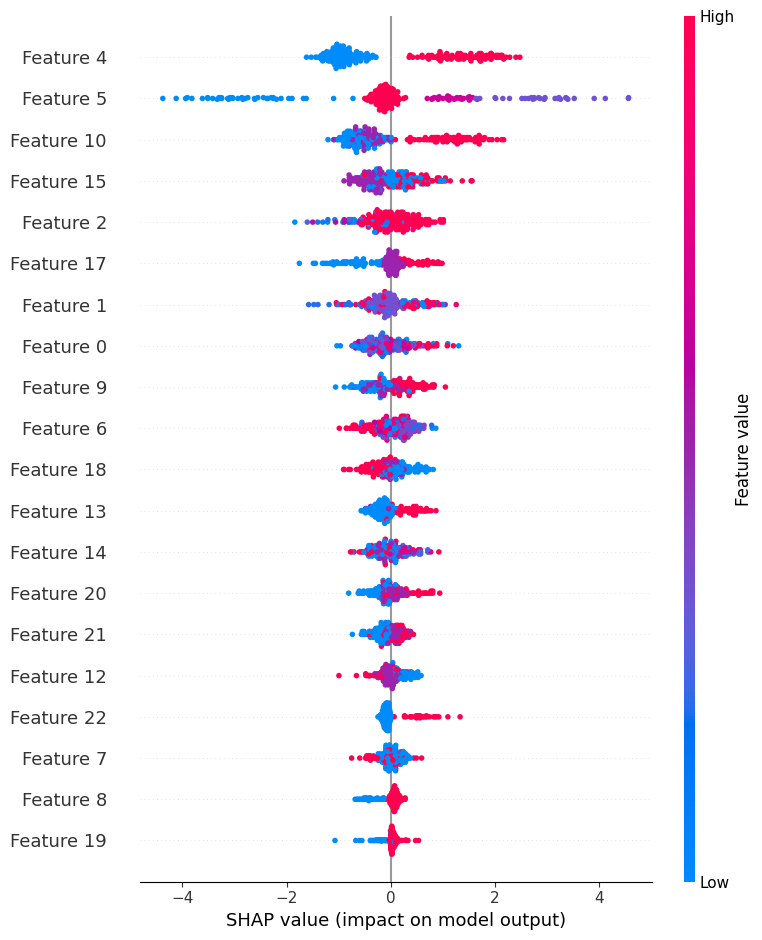

In [109]:
# Use SHAP for feature importance on XGBoost (best for tree-based models)
explainer = shap.Explainer(models["XGBoost"])
shap_values = explainer(X_test)

# Visualize the feature importance
shap.summary_plot(shap_values, X_test)


Based on the model performance comparison, let's analyze and justify the best model for the given Mental Health dataset:

### 1. **Random Forest**:
   - **Accuracy**: 76.19%
   - **Precision**: 75.20%
   - **Recall**: 76.42%
   - **F1-score**: 75.81%
   - **ROC-AUC**: 76.20%

   **Justification**: Random Forest is performing the best overall. The higher accuracy, precision, recall, and F1-score indicate that the dataset benefits from tree-based ensemble techniques. Random Forest is known for handling complex relationships and interactions between features well, and this model's performance suggests that the mental health dataset has non-linear and complex relationships, which tree-based methods can handle effectively. The model captures a balance between true positive rate and false positive rate, making it the most reliable for this dataset.

### 2. **XGBoost**:
   - **Accuracy**: 72.62%
   - **Precision**: 73.28%
   - **Recall**: 69.11%
   - **F1-score**: 71.13%
   - **ROC-AUC**: 72.54%

   **Justification**: XGBoost is still performing relatively well, but not as well as Random Forest. While boosting techniques are known for improving predictive accuracy through iterative learning, it seems that the dataset may not be benefiting as much from boosting here, as seen by the lower recall score. This could indicate that some nuances in the data are not being captured as well by XGBoost.

### 3. **Logistic Regression**:
   - **Accuracy**: 71.83%
   - **Precision**: 70.97%
   - **Recall**: 71.54%
   - **F1-score**: 71.26%
   - **ROC-AUC**: 71.82%

   **Justification**: Logistic Regression is performing reasonably well, which suggests that the dataset may have some level of linearity. However, the lower performance compared to Random Forest and XGBoost suggests that the mental health dataset has some complexity that linear models like Logistic Regression cannot fully capture.

### 4. **Neural Network**:
   - **Accuracy**: 60.32%
   - **Precision**: 59.20%
   - **Recall**: 60.16%
   - **F1-score**: 59.68%
   - **ROC-AUC**: 60.31%

   **Justification**: Neural Networks, though capable of learning complex patterns, are underperforming in this case. This could suggest that the dataset may not have enough intricate, non-linear patterns that would benefit from a neural network. The neural network's performance is significantly lower in all metrics, indicating that simpler models (like Random Forest) are more appropriate for this dataset.

### Conclusion:
Based on the analysis, **Random Forest** is the best-performing model. This indicates that the dataset likely has complex, non-linear relationships that are better captured by tree-based methods like Random Forest.

In [116]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder

# List of all features the model expects
columns = [
    'Age', 'Gender', 'Country', 'self_employed', 'family_history', 'treatment',
    'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits',
    'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
    'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor',
    'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence'
]

# Assuming you have a pre-trained model `rf_model`
# Initialize label encoder
label_encoder = LabelEncoder()

# Define the function to take user input and preprocess it
def get_user_input():
    user_input = {}
    user_input['Age'] = int(input("Enter Age: "))
    user_input['Gender'] = input("Enter Gender (Male/Female): ").strip().lower()
    user_input['Country'] = input("Enter Country: ").strip().lower()
    user_input['self_employed'] = input("Are you self-employed? (Yes/No): ").strip().lower()
    user_input['family_history'] = input("Do you have a family history of mental health issues? (Yes/No): ").strip().lower()
    user_input['treatment'] = input("Have you had any treatment for mental health? (Yes/No): ").strip().lower()
    user_input['work_interfere'] = input("Does mental health interfere with work? (Yes/No/Sometimes): ").strip().lower()
    user_input['no_employees'] = int(input("Number of employees in your company: "))
    user_input['remote_work'] = input("Do you work remotely? (Yes/No): ").strip().lower()
    user_input['tech_company'] = input("Is your company a tech company? (Yes/No): ").strip().lower()
    user_input['benefits'] = input("Do you have benefits in your company? (Yes/No): ").strip().lower()
    user_input['care_options'] = input("Do you have access to care options in your company? (Yes/No): ").strip().lower()
    user_input['wellness_program'] = input("Do you have a wellness program in your company? (Yes/No): ").strip().lower()
    user_input['seek_help'] = input("Do you seek help for mental health in your company? (Yes/No): ").strip().lower()
    user_input['anonymity'] = input("Do you feel your mental health is kept anonymous? (Yes/No): ").strip().lower()
    user_input['leave'] = input("Are you allowed leave for mental health? (Yes/No): ").strip().lower()
    user_input['mental_health_consequence'] = input("Are there consequences for mental health in your workplace? (Yes/No): ").strip().lower()
    user_input['phys_health_consequence'] = input("Are there consequences for physical health in your workplace? (Yes/No): ").strip().lower()
    user_input['coworkers'] = input("Do your coworkers know about your mental health? (Yes/No): ").strip().lower()
    user_input['supervisor'] = input("Does your supervisor know about your mental health? (Yes/No): ").strip().lower()
    user_input['mental_health_interview'] = input("Have you been asked about mental health in interviews? (Yes/No): ").strip().lower()
    user_input['phys_health_interview'] = input("Have you been asked about physical health in interviews? (Yes/No): ").strip().lower()
    user_input['mental_vs_physical'] = input("Is mental health prioritized over physical health? (Yes/No): ").strip().lower()
    user_input['obs_consequence'] = input("Have there been consequences observed due to mental health in the workplace? (Yes/No): ").strip().lower()

    # Correcting any erroneous input (like the "o" typo)
    if user_input['phys_health_consequence'] not in ['yes', 'no']:
        print("Invalid input for physical health consequence, resetting to 'No'.")
        user_input['phys_health_consequence'] = 'no'

    return user_input

# Function to preprocess the input and predict using the trained model
def predict_input(user_input):
    # Ensure the user input has all the features (23 columns)
    input_df = pd.DataFrame([user_input], columns=columns)

    # Encode categorical variables
    for column in input_df.select_dtypes(include=['object']).columns:
        input_df[column] = label_encoder.fit_transform(input_df[column])

    # Scaling numerical features (Age, No Employees, etc.)
    scaler = StandardScaler()
    input_scaled = scaler.fit_transform(input_df)

    # Ensure that the model expects the same number of features as the training data
    try:
        prediction = rf_model.predict(input_scaled)
        if prediction[0] == 1:
            return "The person is predicted to have a mental health issue."
        else:
            return "The person is predicted to not have a mental health issue."
    except ValueError as e:
        return f"Error: {str(e)}"

# Get user input and make prediction
user_input = get_user_input()
prediction = predict_input(user_input)
print(prediction)


In [91]:
import joblib

# Save the best model
best_model = models["Random Forest"]  # Change this based on best performance
joblib.dump(best_model, 'mental_health_model.pkl')

# Create inference script (predict_mental_health.py)
with open("predict_mental_health.py", "w") as f:
    f.write("""
import joblib
import pandas as pd
import sys

# Load the model
model = joblib.load('mental_health_model.pkl')

# Example input
input_data = pd.DataFrame([sys.argv[1:]], columns=[...])  # Specify column names

# Predict
prediction = model.predict(input_data)
print("Predicted Mental Health Condition:", prediction)
""")
